<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 2 -- Recap Hands-on AI I (Part Two)</h2>

<b>Authors:</b> Brandstetter, Schäfl<br>
<b>Date:</b> 16-03-2020

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
This notebook is designed to run from start to finish. There are different tasks (marked in <span style="color:rgb(208,90,80)">red</span>) which might required small code modifications. Most/All of the used functions are imported from the file <code>u2_utils.py</code> which can be seen and treated as a black box. However, for further understanding you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u2_utils.py</code> need to be installed.

In [1]:
import u2_utils as u2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

from functools import partial
from IPython.display import HTML
from pathlib import Path
from PIL import Image, ImageOps
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from torch.utils.data import DataLoader, TensorDataset

<h3 style="color:rgb(0,120,170)">Module versions</h3>
As mentioned in the introductiory slides, specific minimum versions of Python itself as well as of used modules is recommended.

In [2]:
u2.check_module_versions()

Installed Python version: 3.6 (✗)
Installed numpy version: 1.18.2 (✓)
Installed pandas version: 1.0.3 (✓)
Installed PyTorch version: 1.4.0 (✓)
Installed scikit-learn version: 0.22.1 (✓)
Installed scipy version: 1.4.1 (✓)
Installed matplotlib version: 3.2.1 (✓)
Installed seaborn version: 0.10.0 (✓)
Installed PIL version: 7.0.0 (✓)


<h2>Different classifiers</h2>
In this unit you will be working with a data set composed of various <i>images</i> of fashion items (e.g. shoes or shirts). The data set distinguishes <i>ten</i> different classes, one for each type of fashion item. For curious minds, more information regarding this data set can be found at:<br><br>
<cite>Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747</cite>
<br><br>
Summarizing, the popular Fashion-MNIST data set contains grayscale images of  $n=70000$ different fashion items from ten different classes, namely:<br><br>

| Target   | Name        | Examples                                                  |
|:--------:|:-----------:|:---------------------------------------------------------:|
| 0        | T-shirt/top | ![Image not found!](resources/fashion_mnist_sprite_0.png) |
| 1        | Trouser     | ![Image not found!](resources/fashion_mnist_sprite_1.png) |
| 2        | Pullover    | ![Image not found!](resources/fashion_mnist_sprite_2.png) |
| 3        | Dress       | ![Image not found!](resources/fashion_mnist_sprite_3.png) |
| 4        | Coat        | ![Image not found!](resources/fashion_mnist_sprite_4.png) |
| 5        | Sandal      | ![Image not found!](resources/fashion_mnist_sprite_5.png) |
| 6        | Shirt       | ![Image not found!](resources/fashion_mnist_sprite_6.png) |
| 7        | Sneaker     | ![Image not found!](resources/fashion_mnist_sprite_7.png) |
| 8        | Bag         | ![Image not found!](resources/fashion_mnist_sprite_8.png) |
| 9        | Ankle boot  | ![Image not found!](resources/fashion_mnist_sprite_9.png) |

<br>Below you can see a table with all $70000$ samples (we start to count at 0). Remember, tabular data can have columns in various data types. In our case the $784$ features are given in floating point numbers (recall <i>primitive data types</i>). We would refer to the fashion item type as a <i>label</i> or <i>target</i> rather than a feature, because we want to predict the fashion item type using all other features.

In [3]:
fashion_mnist_data = u2.load_fashion_mnist()
fashion_mnist_data

,PX_0,PX_1,PX_2,PX_3,PX_4,PX_5,PX_6,PX_7,PX_8,PX_9,...,PX_775,PX_776,PX_777,PX_778,PX_779,PX_780,PX_781,PX_782,PX_783,item_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,114.0,130.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Before we can start with classifying the data, we have to split our data set into a <i>training set</i> and into a <i>test set</i>. The training set will be used (as the name suggests) for training the classifier, the test set (as the name also suggests) will be used for testing the classifier on unseen data. Unseen in this sense means that the data has not been used for training and we can therefore get a feeling how good our classifier performs in general.

We now divide the data set between the training set and the test set in the <i>ratio 3:1</i>. Note that the train-test split is performed randomly meaning that by execution of the command the chance that a sample lands in the training (test) set is a prior given by the split ratio. Therefore, we will hardly obtain the same training (test) data set again.

In [4]:
np.random.seed(42)
fashion_mnist_train, fashion_mnist_test = u2.split_data(fashion_mnist_data, test_size=0.25)

print(f'Full data set is of size: {fashion_mnist_data.shape[0]}')
print(f'Training subset is of size: {fashion_mnist_train.shape[0]}')
print(f'Testing subset is of size: {fashion_mnist_test.shape[0]}')

Full data set is of size: 70000
Training subset is of size: 52500
Testing subset is of size: 17500


As most data sets are comprised of samples which are described by a vast amount of features, <i>dimensionality reduction</i> techniques come in very handy. Especially for visualization purposes, projecting samples down to <i>two</i> or <i>three</i> components is a great start on getting your hands on the data set. Moreover, a lower dimensional data set is often required in order to speed up downstream analysis.

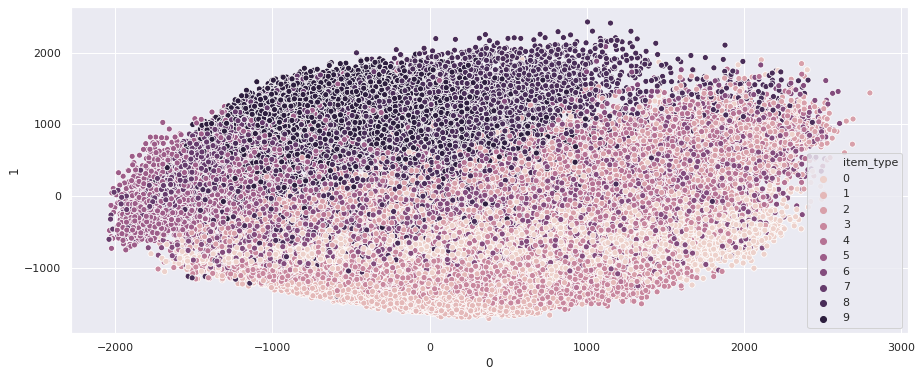

In [5]:
np.random.seed(seed=42)
fashion_mnist_train_pca = u2.apply_pca(n_components=2, data=fashion_mnist_train, target_column=r'item_type')
u2.plot_points_2d(data=fashion_mnist_train_pca, target_column=r'item_type', figsize=(15, 6))

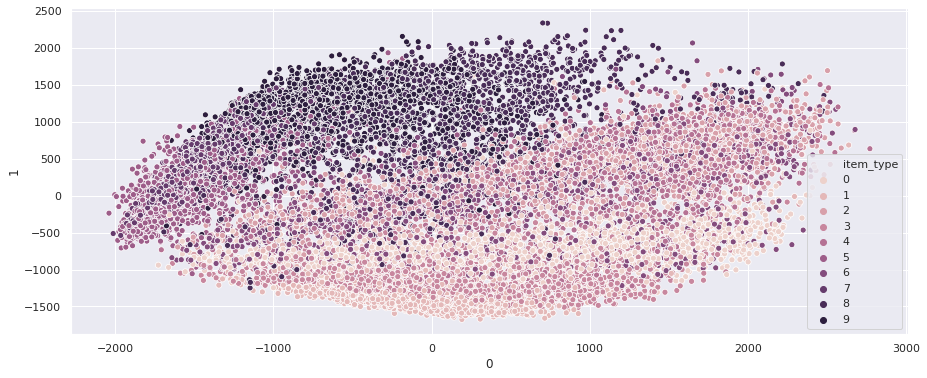

In [6]:
np.random.seed(seed=42)
fashion_mnist_test_pca = u2.apply_pca(n_components=2, data=fashion_mnist_test, target_column=r'item_type')
u2.plot_points_2d(data=fashion_mnist_test_pca, target_column=r'item_type', figsize=(15, 6))

<h3 style="color:rgb(0,120,170)">$k$-nearest neighbors</h3>
Suppose we have a labeled data set (as we have with the seed data set) and a distance measure on the input space. The <i>$k$-nearest neighbors</i> classifier assigns class values according to the class that occurs most often among $k$ samples closest to the input vector $\boldsymbol{x}$.<br><br>

<img src="resources/knn_sketch.png" width="400" align="center"/>

Now it is time to evoke the <i>$k$-nearest neighbors classifier</i>. The only important parameter for the method is the number of neighbors <i>n_neighbors</i> which determines how many ($k$) samples will be taken into account for obtaining the class of an input sample.

In [7]:
np.random.seed(42)
k_range = [1, 12, 24, 48, 96]
for n_neighbors in k_range:
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
    knn_classifier.fit(fashion_mnist_train_pca.drop(columns=r'item_type'), fashion_mnist_train_pca[r'item_type'])
    knn_score = knn_classifier.score(fashion_mnist_test_pca.drop(columns=r'item_type'), fashion_mnist_test_pca[r'item_type'])
    print(f'Score (k = {str(n_neighbors).zfill(len(str(max(k_range))))}): {knn_score}')

Score (k = 01): 0.45171428571428573
Score (k = 12): 0.5429714285714285
Score (k = 24): 0.5574857142857143
Score (k = 48): 0.5600571428571428
Score (k = 96): 0.5630285714285714


A trained classifier does not only work on the points used for training (or testing) but on every point in the input space. Next, we therefore have a look how any point would be classified. The lines between the different classification regions are called <i>decision boundaries</i>. The following cell allows to obtain the decision boundaries for any combination of two input variables.

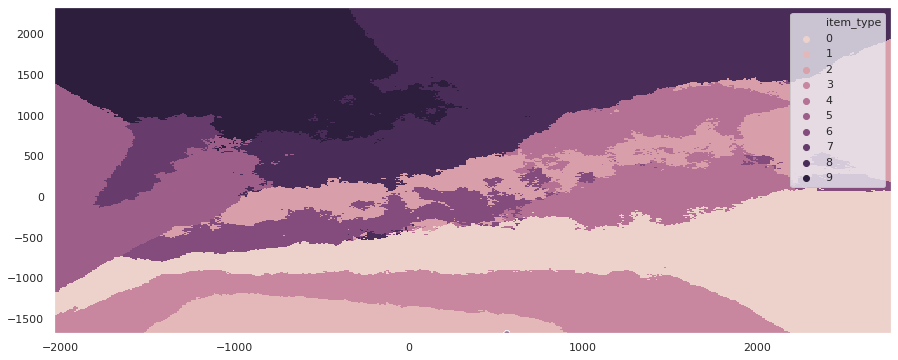

In [8]:
np.random.seed(42)
knn_classifier = KNeighborsClassifier(n_neighbors=96, n_jobs=-1)
knn_classifier.fit(fashion_mnist_train_pca.drop(columns=r'item_type'), fashion_mnist_train_pca[r'item_type'])
u2.plot_decision_boundaries(data=fashion_mnist_test_pca, classifier=knn_classifier, granularity=10.0, figsize=(15, 6))

We have already got into contact with the $k$-nearest neighbors classification method. We now extend to three other methods, namely: <i>Naive Bayes</i>, <i>Random Forest</i> and <i>XGBoost</i>. In the following, we train and test the three different classifiers. Moreover, for the NaiveBayes and the Random Forest classifiers we have a closer look on how they perform if trained only on two feature variables and we plot the decision boundaries for serveral combinations of any two feature variables.

<h3 style="color:rgb(0,120,170)">Naive Bayes</h3>

In [9]:
np.random.seed(42)
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(fashion_mnist_train_pca.drop(columns=r'item_type'), fashion_mnist_train_pca[r'item_type'])
naive_bayes_score = naive_bayes_classifier.score(fashion_mnist_test_pca.drop(columns=r'item_type'), fashion_mnist_test_pca[r'item_type'])
print(f'Score: {naive_bayes_score}')

Score: 0.5061142857142857


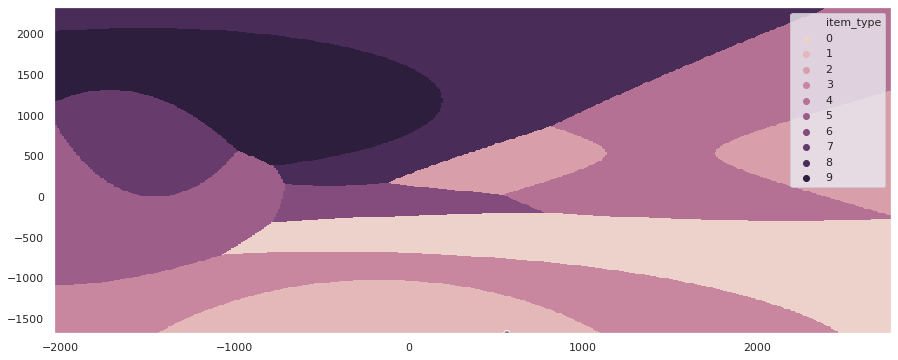

In [10]:
u2.plot_decision_boundaries(data=fashion_mnist_test_pca, classifier=naive_bayes_classifier, granularity=10.0, figsize=(15, 6))

<h3 style="color:rgb(0,120,170)">Random Forest</h3>

In [11]:
np.random.seed(42)
n_estimator_range = [12, 24, 48, 96, 192]
for n_estimator in n_estimator_range:
    random_forest_classifier = RandomForestClassifier(n_estimators=n_estimator, n_jobs=-1)
    random_forest_classifier.fit(fashion_mnist_train_pca.drop(columns=r'item_type'), fashion_mnist_train_pca[r'item_type'])
    random_forest_score = random_forest_classifier.score(fashion_mnist_test_pca.drop(columns=r'item_type'), fashion_mnist_test_pca[r'item_type'])
    print(f'Score (n = {str(n_estimator).zfill(len(str(max(n_estimator_range))))}): {random_forest_score}')

Score (n = 012): 0.5003428571428571
Score (n = 024): 0.5056571428571428
Score (n = 048): 0.5070857142857143
Score (n = 096): 0.5103428571428571
Score (n = 192): 0.5093714285714286


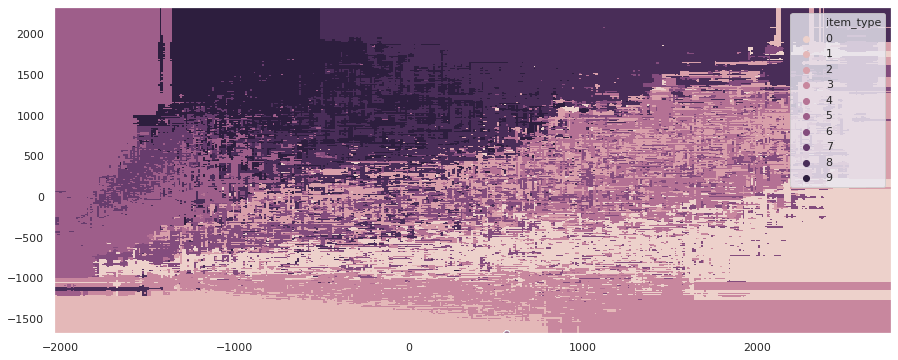

In [12]:
np.random.seed(42)
random_forest_classifier = RandomForestClassifier(n_estimators=192, n_jobs=-1)
random_forest_classifier.fit(fashion_mnist_train_pca.drop(columns=r'item_type'), fashion_mnist_train_pca[r'item_type'])
u2.plot_decision_boundaries(data=fashion_mnist_test_pca, classifier=random_forest_classifier, granularity=10.0, figsize=(15, 6))

<h3 style="color:rgb(0,120,170)">XGBoost</h3>
The values in the next cell (with <i>n_estimators</i> as the exception) are the default values provided by the <code>xgboost</code> module (you can see them as fixed for now). Adjusting the hyperparameters to your problem is one of the challenges in machine learning.

In [13]:
np.random.seed(42)
xgboost_classifier = xgb.XGBClassifier(max_depth=7, min_child_weight=1, learning_rate=0.1, n_estimators=192, silent=True, objective=r'binary:logistic',
                                       gamma=0, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=0,
                                       scale_pos_weight=1, seed=1, missing=None)
xgboost_classifier.fit(fashion_mnist_train_pca.drop(columns=r'item_type'), fashion_mnist_train_pca[r'item_type'])
xgboost_score = xgboost_classifier.score(fashion_mnist_test_pca.drop(columns=r'item_type'), fashion_mnist_test_pca[r'item_type'])
print(f'Score: {xgboost_score}')

Score: 0.5600571428571428


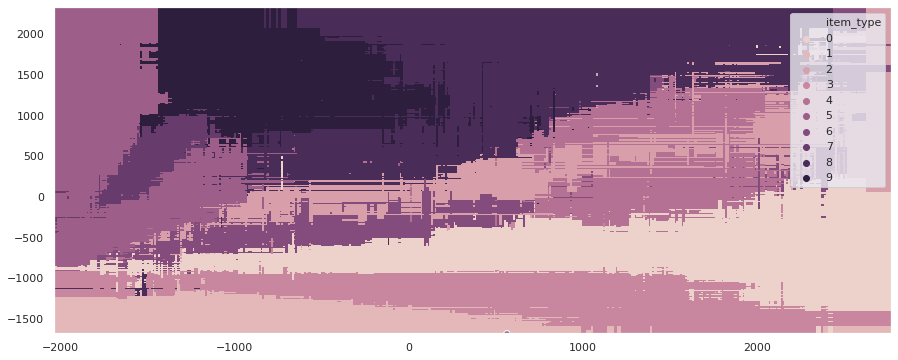

In [14]:
u2.plot_decision_boundaries(data=fashion_mnist_test_pca, classifier=xgboost_classifier, granularity=10.0, figsize=(15, 6))

<h3>Neural Networks (NNs)</h3>

<h3 style="color:rgb(0,120,170)">Loss function</h3>
Short story: the loss function tells you <i>how good your prediction is</i>. In Machine Learning, we try to minimize a cost/loss function. This function gives you the error on our predictions. And if we know the error, we can then optimize to reduce this error. In practice, we often use a loss function like the <i>mean squared error</i>:<br><br>
\begin{equation}MSE = \frac{1}{N}\cdot\sum_{i=1}^{N}\big(y_{i} - \hat{y}_{i}\big)^{2}\end{equation}

Or, especially in in classification tasks, the <i>cross-entropy loss</i>:<br><br>
\begin{equation}CEL = -\frac{1}{N}\cdot\sum_{i=1}^{N}\bigg[y_{i}\log{\hat{y}_{i}} + \big(1 - y_{i}\big)\log{\big(1 - \hat{y}_{i}\big)}\bigg]\end{equation}<br>

In both cases (or generally in Machine Learning), $y$ denotes the true target whereas $\hat{y}$ the prediction of an underlying model. In this context, the subscript $i$ is often called <i>index</i>, and indicates the <i>i-th</i> target, or prediction, respectively. Keep in mind, especially in Machine Learning, the <i>logarithm</i> refers to the <i>natural</i>, not the <i>decadic</i> one.

<h4>Convex function</h4>
A strictly convex loss function is the easiest loss function since it <i>has only one minimum</i>. It is therefore easy to optimize and to understand. For this very purpose, we define $\ldots$

- $\ldots y = x^{d}_{0} + x^{d}_{1} + \ldots{} + x^{d}_{n}$&emsp;as a <i>Python</i> function.
- $\ldots$ the corresponding <i>derivative</i> as a <i>Python</i> function.

In [15]:
degree = 2

def convex_function(x: np.array, degree: int) -> np.array:
    assert degree >= 0
    return np.power(x, degree).sum(axis=0)
convex_function = partial(convex_function, degree=degree)

def convex_function_derivative(x: np.array, degree: int) -> np.array:
    assert degree >= 0
    return degree * np.power(x, degree - 1)
convex_function_derivative = partial(convex_function_derivative, degree=degree)

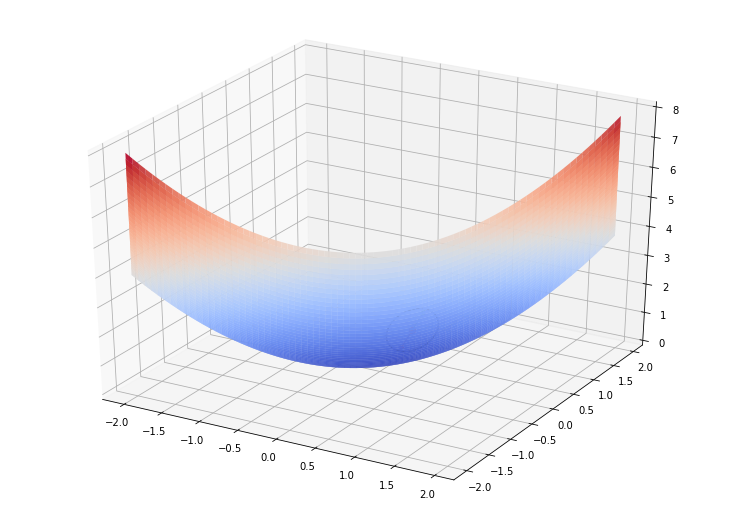

In [16]:
data_arange = pd.DataFrame({r'x': np.arange(-2, 2, 0.05), r'y': np.arange(-2, 2, 0.05)})
u2.plot_function(x0=[0.0, 0.75], data=data_arange, loss_function=convex_function,
                 loss_function_gradient=convex_function_derivative, figsize=(10, 7))

<h4>Non-convex function</h4>
Non-convex loss functions are harder to handle since they have different <i>local</i> and <i>global</i> minima. They are therefore difficult to optimize and difficult to understand. But unfortunately, they are pretty common in machine learning. For this very purpose, we define $\ldots$

- $\ldots y = \tanh{\left(x^{d}_{0} + x^{d}_{1} + \ldots{} + x^{d}_{n}\right)}$&emsp;as a <i>Python</i> function.
- $\ldots$ the corresponding <i>derivative</i> as a <i>Python</i> function.

In [17]:
degree = 3

def non_convex_function(x: np.ndarray, degree: int) -> np.ndarray:
    assert degree >= 0
    #return np.tanh(np.power(x, degree).sum(axis=0))
    return np.power(x, degree).sum(axis=0)
non_convex_function = partial(non_convex_function, degree=degree)

def non_convex_function_derivative(x: np.ndarray, degree: int) -> np.ndarray:
    assert degree >= 0
    #return (1 - np.power(non_convex_function(x, degree=degree), 2)) * (degree * np.power(x, degree - 1))
    return (degree * np.power(x, degree - 1))
non_convex_function_derivative = partial(non_convex_function_derivative, degree=degree)

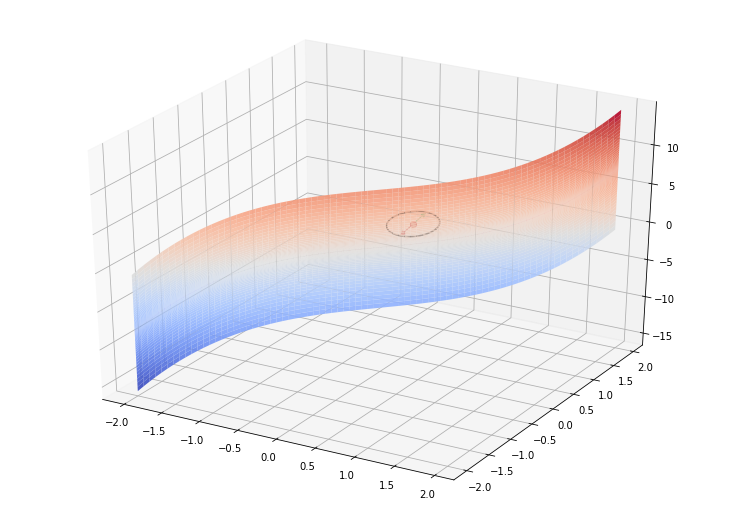

In [18]:
data_arange = pd.DataFrame({r'x': np.arange(-2, 2, 0.05), r'y': np.arange(-2, 2, 0.05)})
u2.plot_function(x0=[0.0, 0.75], data=data_arange, loss_function=non_convex_function,
                 loss_function_gradient=non_convex_function_derivative, figsize=(10, 7))

<h3 style="color:rgb(0,120,170)">Gradient descent</h3>
Gradient descent is an <i>iterativ optimization algorithm</i> for finding the minimum of a function. To find a local minimum of a function using gradient descent, one takes steps in the <i>direction of the negative of the gradient of the function</i> at the current point. If, instead, one takes steps in the direction to the positive of the gradient, one approaches a local maximum of that function – for this reason gradient descent is also known as method of steepest descent.

<h4>Convex function</h4>
We again start with a strictly convex function and see how the gradient descent algorithm obtains a minimum. For this very purpose, we define $\ldots$

- $\ldots y = x^{d}_{0} + x^{d}_{1} + \ldots{} + x^{d}_{n}$&emsp;as a <i>Python</i> function.
- $\ldots$ the corresponding <i>derivative</i> as a <i>Python</i> function.

In [19]:
degree = 2

def convex_function_h(x: np.array, degree: int) -> np.array:
    assert degree >= 0
    return np.power(x, degree).sum(axis=0)
convex_function = partial(convex_function, degree=degree)

def convex_function_derivative(x: np.array, degree: int) -> np.array:
    assert degree >= 0
    return (degree * np.power(x, degree - 1))
convex_function_derivative = partial(convex_function_derivative, degree=degree)

In [20]:
file_name = r'gradient_descent_convex.gif'
if not Path(f'resources/{file_name}').exists():
    data_arange = pd.DataFrame({r'x': np.arange(-2, 2, 0.05), r'y': np.arange(-2, 2, 0.05)})
    gradient_descent_animation = u2.animate_gradient_descent(
        x0=[1.0, 1.0], data=data_arange, n_updates=250, learning_rate=1e-2, momentum=0.0,
        loss_function=convex_function, loss_function_gradient=convex_function_derivative,
        file_name=file_name, figsize=(10, 7))
HTML(f'<img src="resources/{file_name}" align="center"/>')

<h4>Non-convex function</h4>
As already discussed, non-convex loss functions are harder to handle since they have different <i>local</i> and <i>global</i> minima. There is always the danger that the gradient descent algorithms ends up in a local minimum. We will demonstrate this now. For this very purpose, we define $\ldots$

- $\ldots y = \tanh{\left(x^{d}_{0} + x^{d}_{1} + \ldots{} + x^{d}_{n}\right)}$&emsp;as a <i>Python</i> function.
- $\ldots$ the corresponding <i>derivative</i> as a <i>Python</i> function.

In [21]:
degree = 3

def non_convex_function(x: np.ndarray, degree: int) -> np.ndarray:
    assert degree >= 0
    #return np.tanh(np.power(x, degree).sum(axis=0))
    return np.power(x, degree).sum(axis=0)
non_convex_function = partial(non_convex_function, degree=degree)

def non_convex_function_derivative(x: np.ndarray, degree: int) -> np.ndarray:
    assert degree >= 0
    #return (1 - np.power(non_convex_function(x, degree=degree), 2)) * (degree * np.power(x, degree - 1))
    return degree * np.power(x, degree - 1)
non_convex_function_derivative = partial(non_convex_function_derivative, degree=degree)

In [22]:
file_name = r'gradient_descent_non_convex.gif'
if not Path(f'resources/{file_name}').exists():
    data_arange = pd.DataFrame({r'x': np.arange(-2, 2, 0.05), r'y': np.arange(-2, 2, 0.05)})
    gradient_descent_animation = u2.animate_gradient_descent(
        x0=[1.0, 1.0], data=data_arange, n_updates=250, learning_rate=2e-2, momentum=0.0,
        loss_function=non_convex_function, loss_function_gradient=non_convex_function_derivative,
        file_name=file_name, figsize=(10, 7))
HTML(f'<img src="resources/{file_name}" align="center"/>')

<h4>Momentum term</h4>
The basic idea of momentum in machine learning is to increase the speed of training. The name momentum stems from an analogy to momentum in physics: the weight vector, thought of as a particle traveling through parameter space, incurs acceleration from the gradient of the loss ("force"). Unlike in classical gradient descent, adding a momentum term helps the weight vector to <i>keep traveling in the same direction</i>, preventing oscillations. The weight vector also <i>keeps speed in flat regions</i> of the loss landscape.

In [23]:
degree = 2

def convex_function(x: np.array, degree: int) -> np.array:
    assert degree >= 0
    return np.power(x, degree).sum(axis=0)
convex_function = partial(convex_function, degree=degree)

def convex_function_derivative(x: np.array, degree: int) -> np.array:
    assert degree >= 0
    return degree * np.power(x, degree - 1)
convex_function_derivative = partial(convex_function_derivative, degree=degree)

In [24]:
file_name = r'gradient_descent_convex_momentum.gif'
if not Path(f'resources/{file_name}').exists():
    data_arange = pd.DataFrame({r'x': np.arange(-2, 2, 0.05), r'y': np.arange(-2, 2, 0.05)})
    gradient_descent_animation = u2.animate_gradient_descent(
        x0=[1.0, 1.0], data=data_arange, n_updates=50, learning_rate=1e-2, momentum=0.9,
        loss_function=convex_function, loss_function_gradient=convex_function_derivative,
        file_name=file_name, figsize=(10, 7))
HTML(f'<img src="resources/{file_name}" align="center"/>')

In [25]:
degree = 3

def non_convex_function(x: np.ndarray, degree: int) -> np.ndarray:
    assert degree >= 0
    #return np.tanh(np.power(x, degree).sum(axis=0))
    return np.power(x, degree).sum(axis=0)
non_convex_function = partial(non_convex_function, degree=degree)

def non_convex_function_derivative(x: np.ndarray, degree: int) -> np.ndarray:
    assert degree >= 0
    #return (1 - np.power(non_convex_function(x, degree=degree), 2)) * (degree * np.power(x, degree - 1))
    return degree * np.power(x, degree - 1)
non_convex_function_derivative = partial(non_convex_function_derivative, degree=degree)

In [26]:
file_name = r'gradient_descent_non_convex_momentum.gif'
if not Path(f'resources/{file_name}').exists():
    data_arange = pd.DataFrame({r'x': np.arange(-2, 2, 0.05), r'y': np.arange(-2, 2, 0.05)})
    gradient_descent_animation = u2.animate_gradient_descent(
        x0=[1.0, 1.0], data=data_arange, n_updates=250, learning_rate=2e-2, momentum=0.5,
        loss_function=non_convex_function, loss_function_gradient=non_convex_function_derivative,
        file_name=file_name, figsize=(10, 7))
HTML(f'<img src="resources/{file_name}" align="center"/>')

<h3 style="color:rgb(0,120,170)">Under- and overfitting</h3>
Before applying more complex <i>machine learning</i> methods, a short recapitulation of <i>underfitting</i> and <i>overfitting</i> might be quite appropriate. Given the following interesting function definition, the <i>Weierstrass function</i> (which is continuous, but <i>not</i> differentiable): <br>

The following Weierstrass function is used:
\begin{align}
    &f(x) = \sum_{n=0}^{\infty} a^n \cos(b^n\pi x), \\
    &0\geq a \geq 1 \\
    &ab\geq 1+\frac{3}{2}\pi
\end{align}

In [27]:
def Weierstrass(x, b: float = 20):
    assert b >= 7
    a = (1 + ((3 * np.pi) / 2)) / b
    a *= 1.01
    assert 0 < a < 1
    return np.sum([np.power(a, n) * np.cos(np.power(b, n) * np.pi * x) for n in range(100)], axis=0)

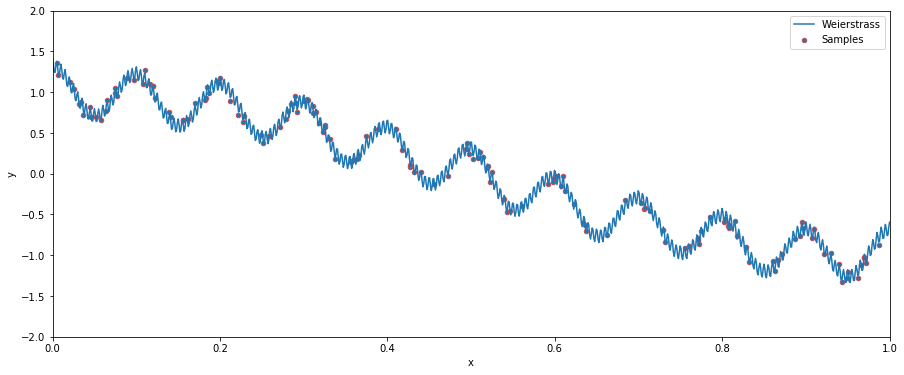

In [28]:
# Generate random samples and evaluate Weierstrass function.
np.random.seed(42)
x = np.sort(np.random.rand(150))
y = Weierstrass(x=x)

# Plot Weierstrass function.
fig = plt.figure(figsize=(15, 6))
function_range = np.linspace(0, 1, 1000)
plt.plot(function_range, Weierstrass(x=function_range), label=r'Weierstrass')
plt.scatter(x, y, edgecolor=r'r', s=20, label=r'Samples')
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.legend(loc="best")
plt.show()

If a model is way too simple to fit the data (e.g. in our case the polynomial of degree $1$, as seen below), we say that this model has a <i>high bias</i>. It will perform equally bad on the training and on the test set i.e. it has a systematic error due to its low complexity.<br><br>
On the other hand, if the model is too complex, it will exactly fit the training data, disregarding the underlying structure of the data. For example, the polynomial of degree $150$ tries to fit every data point exactly but makes nonsensical, highly varying predictions in-between (as seen below). We say the model has <i>high variance</i>.<br><br>
The golden grail in Machine Learning is to find the correct <i>bias-variance trade-off</i>.

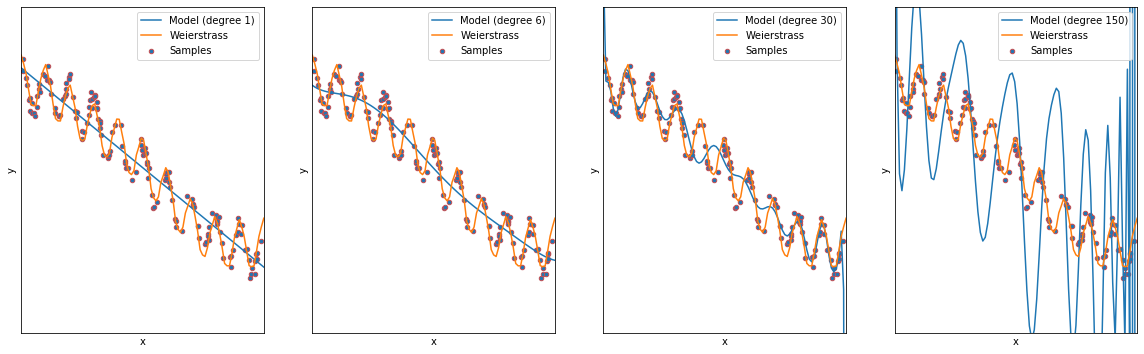

In [29]:
np.random.seed(42)
degrees = [1, 6, 30, 150]

# Plot Weierstrass function and corresponding regression models.
plt.figure(figsize=(20, 6))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    # Fit a polynomial with respect to our sample data.
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([(r'polynomial_features', polynomial_features),
                         (r'linear_regression', linear_regression)])
    pipeline.fit(x[:, np.newaxis], y)

    # Create subplot and show result of currently fitted model.
    function_range = np.linspace(0, 1, 100)
    label = f'Model (degree {degrees[i]})'
    plt.plot(function_range, pipeline.predict(function_range[:, np.newaxis]),label=label)
    plt.plot(function_range, Weierstrass(function_range), label=r'Weierstrass')
    plt.scatter(x, y, edgecolor=r'r', s=20, label=r'Samples')
    plt.xlabel(r'x')
    plt.ylabel(r'y')
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc=r'best')
plt.show()

It seems that a polynomial of degree $1$ fits the data pretty bad (unsurprisingly). This is termed <i>underfitting</i>. On the other hand, a polynomial of degree $30$ does the job pretty well. Higher polynomials tend to fit to each individual data point and therefore are <i>prone to overfit</i>.

<h3>Convolutional neural networks (CNNs)</h3>
A <i>convolutional neural network</i> (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing all sorts of images. The name indicates that the network employs a <i>mathematical operation</i> called <i>convolution</i>. Convolutional networks are any neural networks that use convolution in place of general matrix multiplication in at least one of their layers.<br><br>
Like other neural networks, a convolutional neural network consists of an input and an output layer, as well as multiple hidden layers. The hidden layers of a CNN typically consist of a series of <i>convolutional layers</i>, <i>pooling layers</i>, and <i>fully connected layers</i>. Though the layers are colloquially referred to as convolutions, this is only by convention. Mathematically, it is technically a sliding dot product or <i>cross-correlation</i>.<br><br>

<img src="resources/cnn_sketch.jpg" width="700" align="center"/>
<center>Image taken from: <cite>Peng et al. "Dual Temporal Scale Convolutional Neural Network for Micro-Expression Recognition". in Front Psychol. (2017)</cite></center><br><br><br><br>

<img src="resources/cnn_architecture.jpg" width="700" align="center"/>
<center>Image provided by <a href=https://www.jku.at/en/institute-for-machine-learning/about-us/team/elisabeth-rumetshofer/><i>Elisabeth Rumetshofer</i></a>.</center>

<h3 style="color:rgb(0,120,170)">Convolution</h3>

<i>Convolution</i> is a mathematical operation on two functions to produce a third function that expresses how the shape of one function is modified by the other function. The term convolution refers to both the result function and to the process of computing it. In a neural network, we will perform the convolution operation on the input image matrix to reduce its shape. <br><br>

<img src="resources/cnn_concept.jpg" width="400" align="center"/>

<br>The convolutional layer's parameters consist of a set of learnable filters (or <i>kernels</i>), which have a small receptive field, but extend through the full depth of the input volume. During the forward pass, each filter is convolved across the width and height of the input volume, computing the dot product between the entries of the filter and the input and producing a 2-dimensional activation map of that filter. 

As a result, the network learns filters that activate when it detects some specific type of feature at some spatial position in the input. Before digging into <i>convolutional neural networks</i> (or any more sophisticated method), it is always a good idea to get more familiar with the <i>basics</i> first. For this very purpose, we define the <i>Prewitt operator</i> for the <i>horizontal</i> as well as the <i>vertical</i> approximations of the derivatives of the <i>image intensity function</i> as <i>numpy</i> arrays:

\begin{equation}P_x = \left( 
    \begin{array}{rrr}                                
        1 & 0 & -1 \\
        1 & 0 & -1 \\
        1 & 0 & -1 \\
    \end{array}\right)
\end{equation}

\begin{equation}P_y = \left( 
    \begin{array}{rrr}                                
        1 & 1 & 1 \\
        0 & 0 & 0 \\
        -1 & -1 & -1 \\
    \end{array}\right)
\end{equation}

Afterwards we load a beautiful image of our renowned research dog <i>Charlie</i>, convert it to the <i>grayscale</i> color model and apply both filters on it.

In [30]:
prewitt_x = np.asarray([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
prewitt_y = np.asarray([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

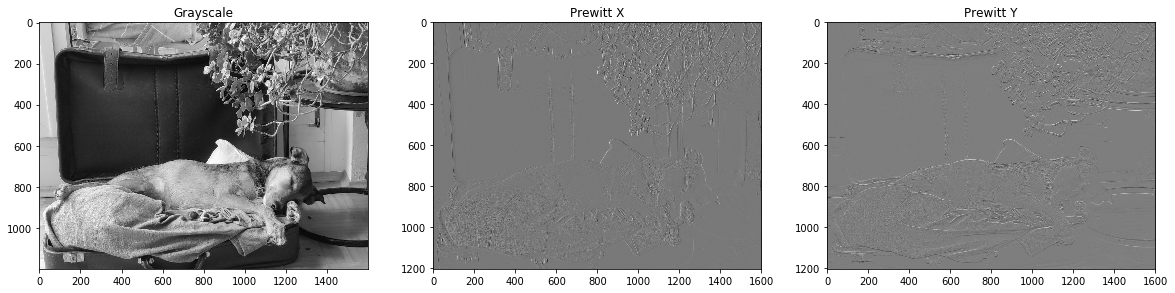

In [31]:
image_path = r'resources/charlie_1.jpg'
with Image.open(image_path) as image_data:
    image_charlie = ImageOps.grayscale(image_data)

# Define figure and corresponding attributes.
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].set_title(r'Grayscale')
ax[1].set_title(r'Prewitt X')
ax[2].set_title(r'Prewitt Y')

# Show grayscale image of Charlie.
_ = ax[0].imshow(image_charlie, cmap=r'gray')

# Apply custom filter to grayscale image of Charlie.
_ = ax[1].imshow(signal.convolve2d(np.array(image_charlie), prewitt_x), cmap=r'gray')
_ = ax[2].imshow(signal.convolve2d(np.array(image_charlie), prewitt_y), cmap=r'gray')

<h3 style="color:rgb(0,120,170)">Activation</h3>

To get a better feeling for <i>manually</i> defined and <i>fixed</i> filters of <i>convolutional neural networks</i> as well as to demonstrate the <i>rectified linear unit (ReLU)</i> activation function, a second (slightly different) <i>kernel</i> has to be defined. The following is assumed:

\begin{equation}G_c = \left( 
    \begin{array}{rrrrr}                                
        -1 & -0.5 & 0.0 & 0.5 & 1 \\
        -1 & -0.5 & 0.0 & 0.5 & 1 \\
        -1 & -0.5 & 0.0 & 0.5 & 1 \\
        -1 & -0.5 & 0.0 & 0.5 & 1 \\
        -1 & -0.5 & 0.0 & 0.5 & 1
    \end{array}\right)
\end{equation}

In [44]:
custom_kernel_x = np.array([[-1.0, -0.5, 0.0, 0.5, 1.0]] * 5)
custom_kernel_y = custom_kernel_x.transpose()

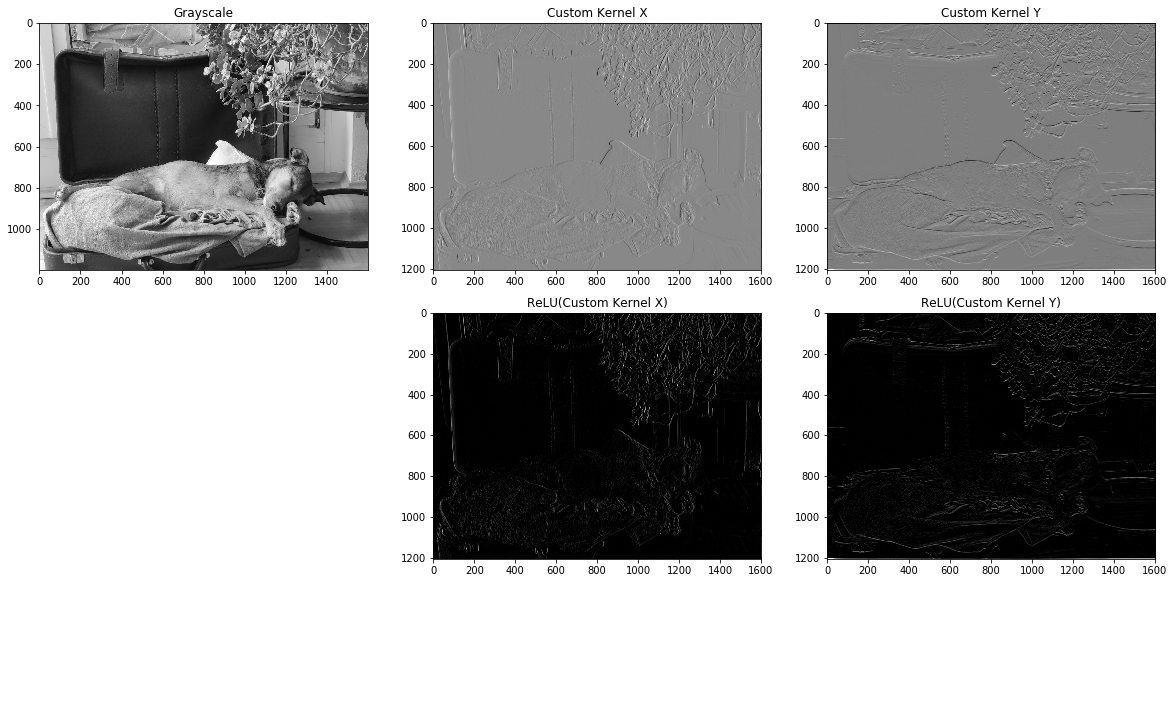

In [45]:
image_path = r'resources/charlie_1.jpg'
with Image.open(image_path) as image_data:
    image_charlie = ImageOps.grayscale(image_data)

# Define figure and corresponding attributes.
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
plt.subplots_adjust(hspace=-0.45)
ax[1, 0].axis(r'off')
ax[0, 0].set_title(r'Grayscale')
ax[0, 1].set_title(r'Custom Kernel X')
ax[0, 2].set_title(r'Custom Kernel Y')
ax[1, 1].set_title(r'ReLU(Custom Kernel X)')
ax[1, 2].set_title(r'ReLU(Custom Kernel Y)')

# Show grayscale image of Charlie.
_ = ax[0, 0].imshow(image_charlie, cmap=r'gray')

# Apply ReLU to grayscale image of Charlie.
filtered_charlie_x = signal.convolve2d(np.array(image_charlie), custom_kernel_x)
_ = ax[0, 1].imshow(filtered_charlie_x, cmap=r'gray')
_ = ax[1, 1].imshow(torch.relu(torch.tensor(filtered_charlie_x)), cmap=r'gray')

filtered_charlie_y = signal.convolve2d(np.array(image_charlie), custom_kernel_y)
_ = ax[0, 2].imshow(filtered_charlie_y, cmap=r'gray')
_ = ax[1, 2].imshow(torch.relu(torch.tensor(filtered_charlie_y)), cmap=r'gray')

<h3 style="color:rgb(0,120,170)">Pooling</h3>
Another important concept of CNNs is <i>pooling</i>, which is a form of non-linear down-sampling. There are several non-linear functions to implement pooling among which <i>max pooling</i> is the most common. It partitions the input image into a set of non-overlapping rectangles and, for each such sub-region, outputs the maximum.<br><br>
Intuitively, the exact location of a feature is less important than its rough location relative to other features. This is the idea behind the use of pooling in convolutional neural networks. The pooling layer serves to progressively reduce the spatial size of the representation, to reduce the number of parameters.<br><br>
On top of the activation we now apply a max pooling operation which takes the <i>maximum value of 2 times 2 pixels</i>.<br><br>

<img src="resources/cnn_max_pooling.jpg" width="400" align="center"/>
<br><br>

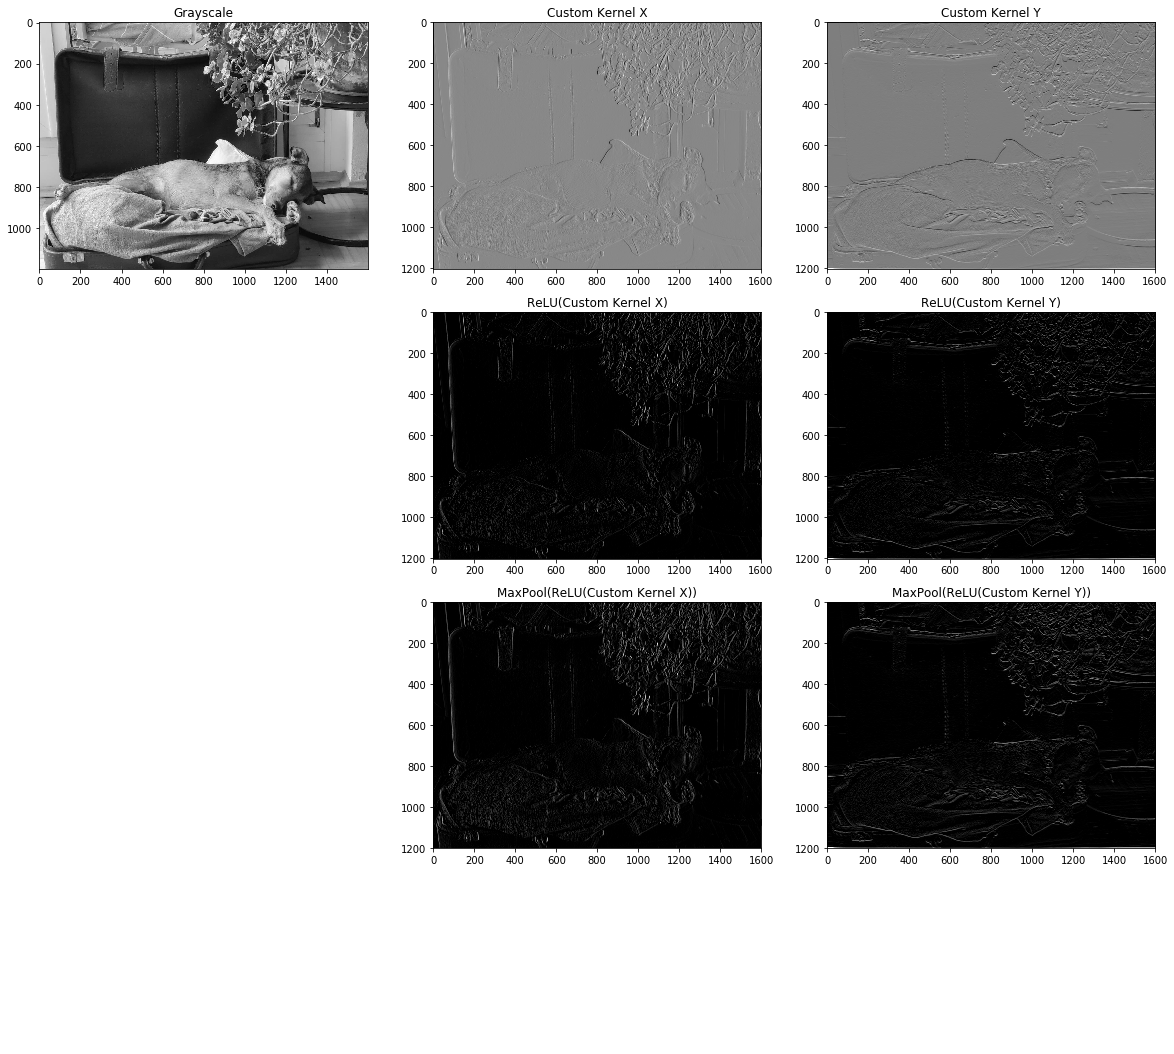

In [34]:
image_path = r'resources/charlie_1.jpg'
with Image.open(image_path) as image_data:
    image_charlie = ImageOps.grayscale(image_data)

# Define figure and corresponding attributes.
fig, ax = plt.subplots(3, 3, figsize=(20, 22.5))
plt.subplots_adjust(hspace=-0.55)
ax[1, 0].axis(r'off')
ax[2, 0].axis(r'off')
ax[0, 0].set_title(r'Grayscale')
ax[0, 1].set_title(r'Custom Kernel X')
ax[0, 2].set_title(r'Custom Kernel Y')
ax[1, 1].set_title(r'ReLU(Custom Kernel X)')
ax[1, 2].set_title(r'ReLU(Custom Kernel Y)')
ax[2, 1].set_title(r'MaxPool(ReLU(Custom Kernel X))')
ax[2, 2].set_title(r'MaxPool(ReLU(Custom Kernel Y))')

# Show grayscale image of Charlie.
_ = ax[0, 0].imshow(image_charlie, cmap=r'gray')

# Apply ReLU to grayscale image of Charlie.
filtered_charlie_x = signal.convolve2d(np.array(image_charlie), custom_kernel_x)
activated_charlie_x = torch.relu(torch.tensor(filtered_charlie_x))
_ = ax[0, 1].imshow(filtered_charlie_x, cmap=r'gray')
_ = ax[1, 1].imshow(activated_charlie_x, cmap=r'gray')

reshaped_charlie_x = activated_charlie_x.unsqueeze(0).unsqueeze(0)
pooled_charlie_x = torch.max_pool2d(reshaped_charlie_x, kernel_size=2, stride=1)
_ = ax[2, 1].imshow(pooled_charlie_x.squeeze(), cmap=r'gray')

filtered_charlie_y = signal.convolve2d(np.array(image_charlie), custom_kernel_y)
activated_charlie_y = torch.relu(torch.tensor(filtered_charlie_y))
_ = ax[0, 2].imshow(filtered_charlie_y, cmap=r'gray')
_ = ax[1, 2].imshow(activated_charlie_y, cmap=r'gray')

reshaped_charlie_y = activated_charlie_y.unsqueeze(0).unsqueeze(0)
pooled_charlie_y = torch.max_pool2d(reshaped_charlie_y, kernel_size=2, stride=1)
_ = ax[2, 2].imshow(pooled_charlie_y.squeeze(), cmap=r'gray')

<h3 style="color:rgb(0,120,170)">Convolutional Neural Network</h3>
In one single layer of a convolutional network, we detect multiple features by convolving our image with different filters. Each convolution operation generates a different 2 dimensions matrix. We then apply activation functions to these matrices. Then all of them were stacked together to form a 3-dimensional output. The third dimension of the final output will be equal to the number of filters used in convolution operation.<br><br>

<img src="resources/cnn_output_channels.jpg" width="450"/>

<br><br>We now look at a very simple convolutional network and study the dimensions: <br>
- One convolutional layer with 10 kernels and kernel size of 5.
- ReLU as the activation function of choice.
- One pooling layer with a max pooling window of 4 times 4 pixels.
- Two fully connected layers.

In [35]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        # nn.Conv2d(in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.fc1 = nn.Linear(10 * 6 * 6, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        
        #Size changes from (1, 28, 28) to (10, 24, 24)
        x = torch.relu(self.conv1(x))
        
        #Size changes from (10, 24, 24) to (10, 6, 6)
        x = torch.max_pool2d(x, 4, 4)
        
        #Size changes from (10, 6, 6) to (10*6*6)
        x = x.view(-1, 10*6*6)
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

Before actually training a <i>convolutional neural network</i> on Fashion-MNIST data, we have to pre-process the images in order to be of the correct shape. Moreover, two <code>Dataloader</code> instances for the <i>training</i> as well as <i>test</i> data sets need to be created.

In [36]:
image_width = int(np.sqrt(len(fashion_mnist_train.iloc[0])))

# Create instance of Dataloader (training set).
fashion_mnist_loader_train = DataLoader(TensorDataset(
    torch.from_numpy(fashion_mnist_train.drop(columns=[r'item_type']).values.astype(
        dtype=np.float32)).unsqueeze(1).reshape(len(fashion_mnist_train), 1, image_width, image_width),
    torch.from_numpy(fashion_mnist_train[r'item_type'].values.astype(dtype=np.long))
), batch_size=128, shuffle=True, drop_last=False)

# Create instance of Dataloader (test set).
fashion_mnist_loader_test = DataLoader(TensorDataset(
    torch.from_numpy(fashion_mnist_test.drop(columns=[r'item_type']).values.astype(
        dtype=np.float32)).unsqueeze(1).reshape(len(fashion_mnist_test), 1, image_width, image_width),
    torch.from_numpy(fashion_mnist_test[r'item_type'].values.astype(dtype=np.long))
), batch_size=128, shuffle=False, drop_last=False)

In [37]:
np.random.seed(42)
torch.manual_seed(42)

target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')
cnn_model = CNN().to(target_device)
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

# Train and evaluate CNN on Fashion-MNIST data.
num_epochs = 3
for epoch in range(num_epochs):
    
    # Train CNN for one epoch.
    u2.train_network(model=cnn_model, data_loader=fashion_mnist_loader_train,
                     device=target_device, optimizer=optimizer)
    
    # Evaluate current CNN model on training data set.
    performance = u2.test_network(
        model=cnn_model, data_loader=fashion_mnist_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')
    
# Evaluate final model on test data set.
performance = u2.test_network(
    model=cnn_model, data_loader=fashion_mnist_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

Epoch: 1 / Loss: 0.0029 / Accuracy: 0.8702
Epoch: 2 / Loss: 0.0023 / Accuracy: 0.8898
Epoch: 3 / Loss: 0.0024 / Accuracy: 0.8845

Final loss: 0.0029 / Final accuracy: 0.8653
